In [ ]:
"""
Titanic Survival Prediction
Author:   Amruth Karun M V
Date:     05-Nov-2021
"""

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Step 1. Install the required libraries, using pip
# numpy, pandas, sklearn, matplotlib

In [ ]:
## Step 2. Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,  KFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
from scipy.stats import uniform
plt.style.use('seaborn')

In [ ]:
## Step 3. Read the dataset into two dataframes - train_pd and test_pd

# Drive path for train data
dataset_path = "/content/drive/MyDrive/ML/titanic/"

# Create pandas dataframe from the input csv files
train_pd = pd.read_csv(dataset_path +"train.csv")
test_pd = pd.read_csv(dataset_path +"test.csv")
print(train_pd.shape)
train_pd.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


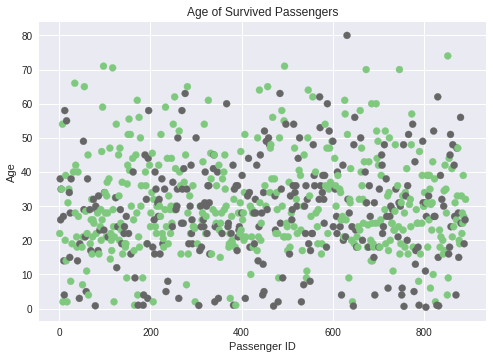

In [ ]:
# Create a scatter plot with the age of passengers
# Survived represented in darker color
plt.scatter(x=train_pd["PassengerId"], y=train_pd["Age"], c=train_pd["Survived"], cmap='Accent')
plt.title("Age of Survived Passengers")
plt.xlabel("Passenger ID")
plt.ylabel("Age")
plt.show()

**Data Preprocessing**

Before building machine learning models, datasets must be preprocessed. The preprocessing phase transforms raw data into clean data. This phase includes steps to handle missing/null values. Common practices include dropping the rows containing missing values or replacing the null values with the mean.

---



In [ ]:
# Remove attributes that are not features
train_pd.drop(columns=['Name','Ticket','PassengerId'], inplace=True)
test_pd.drop(columns=['Name','Ticket','PassengerId'], inplace=True)

In [ ]:
## Calculate entries in training data with missing data
pd.DataFrame({'No. NaN': train_pd.isna().sum(), '%': train_pd.isna().sum() / len(train_pd)})



,No. NaN,%
Survived,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Fare,0,0.000000
Cabin,687,0.771044
Embarked,2,0.002245


In [ ]:
## Calculate entries in test data with missing data
pd.DataFrame({'No. NaN': test_pd.isna().sum(), '%': test_pd.isna().sum() / len(test_pd)})

,No. NaN,%
Pclass,0,0.000000
Sex,0,0.000000
Age,86,0.205742
SibSp,0,0.000000
Parch,0,0.000000
Fare,1,0.002392
Cabin,327,0.782297
Embarked,0,0.000000


Features with missing data:
*   **Cabin (~77%)**: Drop it. Too much data is missing to fill without introducing a significant amount of noise.
*   **Age (~20%)**: A significant amount of data is missing, but if it's useful we can try to fill it.
*   **Fare (1 data point)**: Since only one value is missing we can fill it with something simple like a median.
*   **Embarked (2 data points)**: Only two values missing, but feature is independently correlated with survival. so, it can be dropped






In [ ]:
#Preprocessing - I - Drop 'Cabin' and 'Embarked' feature
train_pd.drop(columns=['Cabin','Embarked'], inplace=True)
test_pd.drop(columns=['Cabin','Embarked'], inplace=True)

In [ ]:
#Preprocessing - II - Pandas has a interpolate() function that will replace all the missing NaNs to interpolated values.

train_pd['Age'] = train_pd['Age'].interpolate()
test_pd['Age'] = test_pd['Age'].interpolate()

In [ ]:
#Preprocessing - III - Fill missing values with median
train_pd['Fare'].fillna(train_pd['Fare'].median(),inplace=True)
test_pd['Fare'].fillna(test_pd['Fare'].median(),inplace=True)

In [ ]:
## Encoding Pclass and Sex attributes
train_dummies = []
test_dummies = []

cols = ['Pclass', 'Sex']
for col in cols:
    train_dummies.append(pd.get_dummies(train_pd[col]))
    test_dummies.append(pd.get_dummies(test_pd[col]))
titanic_train_dummies = pd.concat(train_dummies, axis=1)
titanic_test_dummies = pd.concat(test_dummies, axis=1)

In [ ]:
train_pd = pd.concat((train_pd,titanic_train_dummies), axis=1)
test_pd = pd.concat((test_pd,titanic_test_dummies), axis=1)

In [ ]:
train_pd = train_pd.drop(['Pclass', 'Sex'], axis=1)
test_pd = test_pd.drop(['Pclass', 'Sex'], axis=1)

**Feature Engineering**

Feature Engineering may be applied to generate new features from the existing one. For the Titanic dataset, the features 'SibSp' and 'Patch' can be combined into a single feature, 'FamilySize'

In [ ]:
train_pd['FamilySize'] = train_pd['SibSp'] + train_pd['Parch'] + 1
test_pd['FamilySize'] = test_pd['SibSp'] + test_pd['Parch'] + 1

In [ ]:
#Drop attributes 'SibSp' and 'Parch'
train_pd = train_pd.drop(['SibSp', 'Parch'], axis=1)
test_pd = test_pd.drop(['SibSp', 'Parch'], axis=1)

In [ ]:
#Preprocessed data

train_pd.head()

,Survived,Age,Fare,1,2,3,female,male,FamilySize
0,0,22.0,7.2500,0,0,1,0,1,2
1,1,38.0,71.2833,1,0,0,1,0,2
2,1,26.0,7.9250,0,0,1,1,0,1
3,1,35.0,53.1000,1,0,0,1,0,2
4,0,35.0,8.0500,0,0,1,0,1,1


The data is now preprocessed and cleaned. The cleaned data can now be used to build your model.

In [ ]:
# Calculate percentage of men and women who survived
women = train_pd.loc[train_pd.female == 1]["Survived"]
men = train_pd.loc[train_pd.male == 1]["Survived"]
percentage_women = sum(women)/len(women)
percentage_men = sum(men)/len(men)

print("Percentage of women survived:", percentage_women)
print("Percentage of men survived:", percentage_men)


Percentage of women survived: 0.7420382165605095
Percentage of men survived: 0.18890814558058924


**Train Model - LogisticRegression**
1. (i). Build a Logistic Regression model (with default parameters and
maximum number of iterations set to 1000) to predict the chances of survival for each individual. Split the data in *train.csv* into
training and testing sets in the ratio 80 : 20, with random seed value 78 .

In [ ]:
# Split dataset to train and test
train_pd, test_pd = train_test_split(train_pd, test_size=0.2, random_state=78)

# Get X and y from the combined dataset
# Drop target label 'Survived' from the training data
X_train = train_pd.drop('Survived', axis = 1)
y_train = train_pd['Survived']

X_test = test_pd.drop('Survived', axis = 1)
y_test = test_pd['Survived']

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.776685393258427

1. (ii). Calculate the testing accuracy value. Plot the ROC graph and calculate the AUC score.

Test Accuracy =  0.8324022346368715
Test Accuracy =  0.8324022346368715


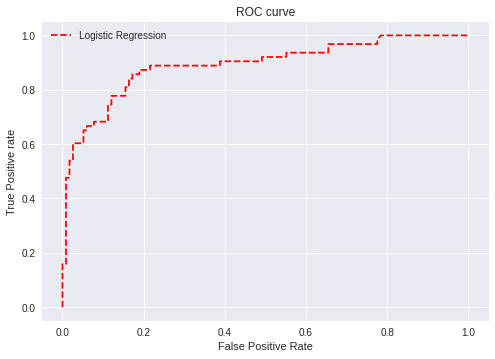

AUC Score =  0.8914203612479475


In [ ]:
# calculate predicted value for test data
y_pred = model.predict(X_test)

# Calculate test acccuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy = ", accuracy)
# or using model.score()
print("Test Accuracy = ", model.score(X_test, y_test))

# Plot ROC graph and calculate AUC score

# predict probabilities
pred_prob = model.predict_proba(X_test)

# Gets the false positive an true positive rates with threshold
# pos_label is set to 1 to indicate the positive class
fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
auc_score = roc_auc_score(y_test, pred_prob[:,1])

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='red', label='Logistic Regression')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

print("AUC Score = ", auc_score)

**K-Fold Cross Validation**
1. (iii). Apply 10-fold cross validation (with random seed value 78) to build a Logistic Regression
model (with default parameters and maximum number of iterations set to 1000).

In [ ]:
''' 
Initialize KFld with 10 folds and seed value 78. 
Calculate the score for the LogisticRegression model
'''
kfold = KFold(n_splits=10, random_state=78, shuffle=True)
train_results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Cross Validated Score = ", train_results)

print("Mean Train Accuracy = ", np.mean(train_results))

Cross Validated Score =  [0.73611111 0.76388889 0.74647887 0.81690141 0.74647887 0.8028169
 0.8028169  0.76056338 0.81690141 0.78873239]
Mean Train Accuracy =  0.7781690140845071


1. (iv). Calculate the mean of test accuracy scores. Compare it with the accuracy value obtained
without using Cross Validation.

In [ ]:
# Calculate cross val score to compute the mean accuracy on test set
test_results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Cross Validated Score = ", test_results)
mean_test_accuracy = np.mean(test_results)

print("Mean Test Accuracy = ", mean_test_accuracy)
print("Initial Test Accuracy = ", accuracy)

if(accuracy < mean_test_accuracy):
  print("Mean cross validation accuracy is greater than initial accuracy!")
else:
  print("Accuracy without cross validation is better!")

Cross Validated Score =  [0.88888889 0.83333333 0.83333333 0.83333333 0.88888889 0.72222222
 0.83333333 0.83333333 0.94444444 0.88235294]
Mean Test Accuracy =  0.8493464052287582
Initial Test Accuracy =  0.8324022346368715
Mean cross validation accuracy is greater than initial accuracy!


**HyperParameter Tuning - Grid Search**
1. (v). Perform hyperparameter tuning using grid search technique to find the best set of hyper-
parameters for the Logistic Regression Model. The grid of parameters is given in Table 1.Provide the
parameters of the best model obtained. Also calculate the test accuracy using the best model.

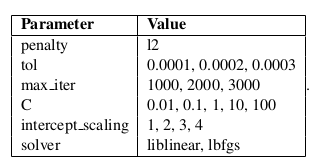

**Grid Search:**
The grid search provided by GridSearchCV in sklearn exhaustively generates candidates from a grid of parameter values specified with the *param_grid* parameter. We can also provide multiple grids and multiple estimators. All the parameter combinations are evaluated and best combination is retained.

---



In [ ]:
# Perform grid search to find the best set of hyperparameters
grid = {'penalty':['l2'], 'tol':[0.0001, 0.0002, 0.0003],
        'max_iter':[1000, 2000, 3000], 'C':[0.01, 0.1, 1, 10, 100],
        'intercept_scaling':[1, 2, 3, 4], 'solver':['liblinear', 'lbfgs']} 
grid_search = GridSearchCV(estimator=model, param_grid=grid) 

# fit train data
grid_search.fit(X_train, y_train)
print("Best Score = ", grid_search.best_score_)
print("Best Parameter = ", grid_search.best_params_)

# Accuracy score for test data
y_pred_grid = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_grid)
print("Test Accuracy using grid search = ", test_accuracy)

Best Score =  0.783689549886733
Best Parameter =  {'C': 0.1, 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Test Accuracy using grid search =  0.8324022346368715


**HyperParameter Tuning - Randomized Search**
1. (vi). Perform hyperparameter tuning using randomized search technique to find the best set of
hyperparameters for the Logistic Regression Model. The grid of parameters is given in Table 2. Provide
the parameters of the best model obtained. Also calculate the test accuracy using the best model.

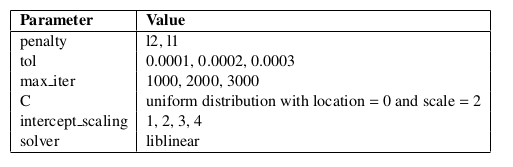


**Randomized Search:** RandomizedSearchCV implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. For each parameter, either a distribution over possible values or a list of discrete choices (which will be sampled uniformly) can be specified:

---






In [ ]:
# Perform randomized search to find the best set of hyperparameters
# use uniform from scipy.stats
random_dist = {'penalty':['l2', 'l1'], 'tol':[0.0001, 0.0002, 0.0003],
               'max_iter':[1000, 2000, 3000], 'C':uniform(loc=0, scale=2),
               'intercept_scaling':[1, 2, 3, 4], 'solver':['liblinear']} 
random_search = RandomizedSearchCV(estimator=model, param_distributions=random_dist)

# fit train data
random_search.fit(X_train, y_train)
print("Best Score = ", random_search.best_score_)
print("Best Parameter = ", random_search.best_params_)

# Accuracy score for test data
# Call predict on the estimator with the best found parameters.
y_pred_random = random_search.predict(X_test)
test_accuracy_random = accuracy_score(y_test, y_pred_random)
print("Test Accuracy using randomized search = ", test_accuracy_random)

Best Score =  0.7780951442923274
Best Parameter =  {'C': 0.05416597322106642, 'intercept_scaling': 3, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0002}
Test Accuracy using randomized search =  0.8491620111731844


**Model Evaluation Metrics:**
1. (vii). Compute the following values for the models built in 1.(i), 1.(v) and 1.(vi):
      * Precision and Recall
      * F1-score
      * Macro, micro and weighted averages of precision, recall and F1-score
 

In [ ]:
'''
Models:
1. (i) - model
1. (v) - grid_search
1. (vi) - random_search

Usually, precision, recall, F1-score are used to evaluate the generalaization
performance of the model.So, we compute these metrics with the predicted values
from the test set using each of the models above.
Here, we already have the predictions avaliable in:
y_pred, y_pred_grid and y_pred_random, and true values in y_true

Use - precision_recall_fscore_support from sklearn to calculate all values
'''

# support is ignored, pos_label=1 return the value for the class 1
# Or it will be an array of float in case of multi-class

# Logistic Regression without hyperparameter tuning
prec_log, recall_log, f1_log, _ =  precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
print("\nLogisticRegression Precision: {}, Recall {}, F1-Score: {}".format(prec_log, recall_log, f1_log))

# Grid Search - use y_pred_grid
prec_grid, recall_grid, f1_grid, _ =  precision_recall_fscore_support(y_test, y_pred_grid, pos_label=1, average='binary')
print("\nGridSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_grid, recall_grid, f1_grid))

# Randomized Search - use y_pred_random
prec_random, recall_random, f1_random, _ =  precision_recall_fscore_support(y_test, y_pred_random, pos_label=1, average='binary')
print("\nRandomizedSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_random, recall_random, f1_random))


LogisticRegression Precision: 0.7323943661971831, Recall 0.8253968253968254, F1-Score: 0.7761194029850745

GridSearch Precision: 0.746268656716418, Recall 0.7936507936507936, F1-Score: 0.7692307692307693

RandomizedSearch Precision: 0.78125, Recall 0.7936507936507936, F1-Score: 0.7874015748031497


**Macro Average:** Macro average calculates the corresponding metric for each of the binary cases, and then averages the results together.

In [ ]:
# Macro average calculation - use average parameter 'macro'
print("Macro Average:")
# Logistic Regression without hyperparameter tuning
prec_log, recall_log, f1_log, _ =  precision_recall_fscore_support(y_test, y_pred, average='macro')
print("\nLogisticRegression Precision: {}, Recall {}, F1-Score: {}".format(prec_log, recall_log, f1_log))

# Grid Search - use y_pred_grid
prec_grid, recall_grid, f1_grid, _ =  precision_recall_fscore_support(y_test, y_pred_grid, average='macro')
print("\nGridSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_grid, recall_grid, f1_grid))

# Randomized Search - use y_pred_random
prec_random, recall_random, f1_random, _ =  precision_recall_fscore_support(y_test, y_pred_random, average='macro')
print("\nRandomizedSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_random, recall_random, f1_random))

Macro Average:

LogisticRegression Precision: 0.8152712571726657, Recall 0.8308018609742747, F1-Score: 0.8210954157782515

GridSearch Precision: 0.8150986140724947, Recall 0.8235495347564312, F1-Score: 0.8188259109311742

RandomizedSearch Precision: 0.8341032608695652, Recall 0.8364805692391899, F1-Score: 0.8352592289600165


**Micro Average:** Micro averaging treats the entire set of data as an aggregate result, and calculates 1 metric rather than k metrics that get averaged together.



In [ ]:
# Micro average calculation - use average parameter 'micro'
print("Micro Average:")
# Logistic Regression without hyperparameter tuning
prec_log, recall_log, f1_log, _ =  precision_recall_fscore_support(y_test, y_pred, average='micro')
print("\nLogisticRegression Precision: {}, Recall {}, F1-Score: {}".format(prec_log, recall_log, f1_log))

# Grid Search - use y_pred_grid
prec_grid, recall_grid, f1_grid, _ =  precision_recall_fscore_support(y_test, y_pred_grid, average='micro')
print("\nGridSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_grid, recall_grid, f1_grid))

# Randomized Search - use y_pred_random
prec_random, recall_random, f1_random, _ =  precision_recall_fscore_support(y_test, y_pred_random, average='micro')
print("\nRandomizedSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_random, recall_random, f1_random))

Micro Average:

LogisticRegression Precision: 0.8324022346368715, Recall 0.8324022346368715, F1-Score: 0.8324022346368715

GridSearch Precision: 0.8324022346368715, Recall 0.8324022346368715, F1-Score: 0.8324022346368715

RandomizedSearch Precision: 0.8491620111731844, Recall 0.8491620111731844, F1-Score: 0.8491620111731844


**Weighted Average:** Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).

In [ ]:
# Weighted average calculation - use average parameter 'weighted'
print("Weighted Average:")
prec_log, recall_log, f1_log, _ =  precision_recall_fscore_support(y_test, y_pred, average='weighted')
print("\nLogisticRegression Precision: {}, Recall {}, F1-Score: {}".format(prec_log, recall_log, f1_log))

# Grid Search - use y_pred_grid
prec_grid, recall_grid, f1_grid, _ =  precision_recall_fscore_support(y_test, y_pred_grid, average='weighted')
print("\nGridSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_grid, recall_grid, f1_grid))

# Randomized Search - use y_pred_random
prec_random, recall_random, f1_random, _ =  precision_recall_fscore_support(y_test, y_pred_random, average='weighted')
print("\nRandomizedSearch Precision: {}, Recall {}, F1-Score: {}".format(prec_random, recall_random, f1_random))

Weighted Average:

LogisticRegression Precision: 0.8398102248916632, Recall 0.8324022346368715, F1-Score: 0.8344123357672929

GridSearch Precision: 0.8354784338483162, Recall 0.8324022346368715, F1-Score: 0.8335105059597856

RandomizedSearch Precision: 0.8497525504007774, Recall 0.8491620111731844, F1-Score: 0.8494293723695915


**Models With and Without Hyperparameter Tuning**
1. (viii). Comment on the models built with and without hyperparameter tuning based on the metric
values.

  Hyperparameter tuning is used to find the best combination of parameters that would give us the best model. Here we built 3 models, one without using hyperparameter tuning and other two using Grid Search and Randomized search respectively, for Logistic Regression. So, from the above calculated parameters we can say that when using the model without hyperparameter tuning, we get a train accuracy of around 0.78 and 0.83 test. We get similar result when using the cross validated data. So, The model we are using is a decent model for the given data. Precision, recall and F1-score are also in the range 0.81 - 0.84. When using *randomized search*, we get around a 2% increase in these metrics value which gives us a better classifier. The quality of the model also depends upon the search space and the distribution we are taking.